In [1]:
#This notebook is for testing ipython widgets to make a GUI for the GREAT Exposure Mapping Program

In [4]:
#Import necessary libraries
import sens_map_lib #main library for the sensitivity |mapper
import numpy as np #numpy
from astropy.modeling import models #For generating synthetic signal on the sky
from matplotlib import pyplot as plt #For plotting

import ipywidgets as widgets #For widgets
from ipywidgets import Layout, HBox, VBox, Label
%matplotlib notebook

from IPython.core.display import display, HTML #Make width of notebook 100% of page
display(HTML("<style>.container { width:100% !important; }</style>"))

Label(value='Upload an .aor file and select an AOR.  If you select more than one AOR, select a primary target …

FileUpload(value={}, accept='.aor', description='Upload AORs')

Label(value='Reciever and frequency information.  Automatically set to the primary frequency of the AOR, but c…

Label(value='Observation parameters automatically set by AOR.  Only adjust if you know what you are doing.')

Label(value='Enter the system temperature $T_{sys}$ from SITE and the desired spectral resolution in km s$^{-1…

HTML(value='<style>p{word-wrap: break-word}</style> <p>Enter sky map information to define the 2D grid the obs…

FloatText(value=1.0, description='Plate-scale (arcsec):', disabled=True, style=DescriptionStyle(description_wi…

Label(value='Enter information about the artificial signal on the sky that will be used to construct the simul…

Dropdown(description='Distribution:', options=('Uniform', '2D Gaussian', 'Ellipse', 'Upload WISE Band 3 FITS F…

FileUpload(value={}, accept='*', description='Upload FITS file', layout=Layout(visibility='hidden'))

Label(value='')

HTML(value='<style>p{word-wrap: break-word}</style> <p>Once everything is set, click Simulate Observation to g…

Button(description='Simulate Observation', style=ButtonStyle())

Label(value='Select map type to view in an interactive plot below.')

RadioButtons(description='Map Type', layout=Layout(width='max-content'), options=('Exposure', 'Artificial Sign…

<IPython.core.display.Javascript object>


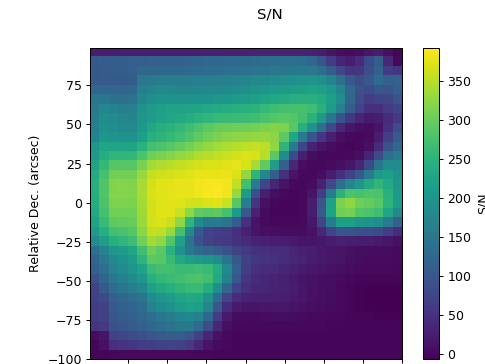

In [5]:

#Load AORs

display(Label(value="Upload an .aor file and select an AOR.  If you select more than one AOR, select a primary target to center map on."))
widget_upload_aor = widgets.FileUpload(accept='.aor', multiple=False, description="Upload AORs",
                                        layout=Layout(position='left'))
widget_select_aor = widgets.SelectMultiple(options=['NONE'], description='Select AOR(s):', disabled=True,
                                    layout=Layout(position='right'), style={'description_width': 'initial'})
widget_select_target = widgets.Dropdown(options=['NONE'], description='Select primary target:', disabled=True, style={'description_width': 'initial'})
display(widget_upload_aor)
display(HBox([widget_select_aor, widget_select_target]))


display(Label(value="Reciever and frequency information.  Automatically set to the primary frequency of the AOR, but can be adjusted by hand."))
reciever_options = ['HFA', 'LFAV', 'LFAH', '4G_4', '4G_3', '4G_2', '4G_1']
widget_select_reciever = widgets.Dropdown(options=reciever_options, value='LFAV', description='Reciever:', )
widget_frequency = widgets.FloatText(description='Frequency (GHz):', value=0., style={'description_width': 'initial'})

display(HBox([widget_select_reciever, widget_frequency]))


display(Label(value="Observation parameters automatically set by AOR.  Only adjust if you know what you are doing."))
widget_total_power_map = widgets.Checkbox(description="Total Power OTF/Raster Map")
widget_non = widgets.IntText(description="$N_{on}$", value=1)
#display(widget_upload_aor, widget_select_aor)/
#display()
display(HBox([widget_total_power_map, widget_non]))


def on_aor_upload(change):
    aors = sens_map_lib.open_aors(widget_upload_aor) #Generate aors class
    aor_ids = [] #Update widget_select_aor options showing the AOR IDs that can now be selected
    targets = []
    for aor in aors:
        aor_ids.append(aor.aor_id)
        targets.append(aor.target)
    widget_select_aor.options = aor_ids
    widget_select_aor.disabled = False
    widget_select_target.options = targets
    widget_select_target.disabled = False
    widget_select_aor.index = [0]
    on_aor_select(0)

widget_upload_aor.observe(on_aor_upload, names='value') #

def on_aor_select(change):
    aors = sens_map_lib.open_aors(widget_upload_aor) #Generate aors class
    if len(widget_select_aor.index) > 0: #Error catch
        aor = aors[widget_select_aor.index[-1]]
        widget_select_target.index = widget_select_aor.index[-1]
        if (aor.map_type == 'GREAT_Raster' or aor.map_type == 'GREAT_OTF' or aor.map_type == 'GREAT_ON_THE_FLY_ARRAY_MAPPING' or aor.map_type == 'GREAT_ON_THE_FLY_HONEYCOMB_MAP') and aor.nod_type == 'Total_Power':
            widget_total_power_map.value = True
        else:
            widget_total_power_map.value = False
        if aor.map_type == 'GREAT_Raster' or aor.map_type == 'GREAT_OTF' or aor.map_type == 'GREAT_ON_THE_FLY_ARRAY_MAPPING':
            widget_non.value = aor.Non
        try:
            primary_frequency = aor.primary_frequency
            widget_select_reciever.value = primary_frequency
            on_reciever_select(0)
        except:
            print("WARNING: Unable to understand primiary frequency '"+primary_frequency+"' for automatically setting the reciever when selecting an aor." )
        
    
widget_select_aor.observe(on_aor_select, names='value')

# output_aors = widget_upload_aor.observe(create_aors)

#aors[0].aor_id


def on_reciever_select(change):
    aors = sens_map_lib.open_aors(widget_upload_aor) #Generate aors class
    aor = aors[widget_select_aor.index[-1]]
    reciever = widget_select_reciever.value
    if reciever == 'HFA':
        widget_frequency.value = aor.frequencies[0] / 1e9
    elif reciever == 'LFAH' or reciever == 'LFA (Combined)' or reciever =='4G_1':
        widget_frequency.value = aor.frequencies[1] / 1e9
    elif reciever == 'LFAV' or reciever == '4G_2':
        widget_frequency.value = aor.frequencies[2] / 1e9
    elif reciever == '4G_3':
        widget_frequency.value = aor.frequencies[3] / 1e9
    elif reciever == '4G_4':
        widget_frequency.value = aor.frequencies[4] / 1e9

widget_select_reciever.observe(on_reciever_select, names='value')


display(Label('Enter the system temperature $T_{sys}$ from SITE and the desired spectral resolution in km s$^{-1}$.'))
widget_tsys = widgets.FloatText(description='$T_{\mbox{sys}}$ (K):', value=0.0, step=1.0)
widget_deltav = widgets.FloatText(description='$\Delta$v (km s$^{-1}$):', value=1.0, style={'description_width': 'initial'}, step=0.1)
display(HBox([widget_tsys, widget_deltav]))


display(widgets.HTML(value= '<style>p{word-wrap: break-word}</style> <p>'+ 'Enter sky map information to define the 2D grid the observation will be simulated on.  In general each reported parameter will be in units of area on the sky defined by the plate scale.  For maps, the plate scale usually is set to the map step size.  Setting the spatial reslution higher and downsampling usually produces better results.'  +' </p>'))


widget_xmin = widgets.FloatText(value=-100.0)
widget_xmax = widgets.FloatText(value=100.0)
widget_ymin = widgets.FloatText(value=-100.0)
widget_ymax = widgets.FloatText(value=100.0)
widget_resolution = widgets.FloatText(value=1.0, description="Spatial resolution in arcsec:", style={'description_width': 'initial'})
widget_downsample = widgets.IntText(value=1.0, description='Downsample', style={'description_width': 'initial'})
widget_platescale = widgets.FloatText(value=1.0, description='Plate-scale (arcsec):',  style={'description_width': 'initial'}, disabled=True)
display(HBox([widget_resolution, widget_downsample]))
display(widget_platescale)
display(HBox([Label(value="x:"), widget_xmax, Label(value=" to "), widget_xmin, Label(value=" arcsec")]))
display(HBox([Label(value="y:"), widget_ymin, Label(value=" to "), widget_ymax, Label(value=" arcsec")]))
        
def update_platescale(change):
    widget_platescale.value = widget_resolution.value * widget_downsample.value

widget_resolution.observe(update_platescale, names='value')
widget_downsample.observe(update_platescale, names='value')



display(Label(value="Enter information about the artificial signal on the sky that will be used to construct the simulated observation."))
widget_signal_select = widgets.Dropdown(description="Distribution:", options=['Uniform', '2D Gaussian', 'Ellipse', 'Upload WISE Band 3 FITS File'])
widget_signal_amplitude = widgets.FloatText(value=1.0, description='$T_a$ (K)', layout=Layout(visibility='visible'))
widget_signal_x0 = widgets.FloatText(value=0.0, description='$x_0$ (arcsec)', layout=Layout(visibility='hidden'))
widget_signal_y0 = widgets.FloatText(value=0.0, description='$y_0$ (arcsec)', layout=Layout(visibility='hidden'))
widget_signal_a = widgets.FloatText(value=1.0, description='$\sigma_x$ (arcsec)', layout=Layout(visibility='hidden'))
widget_signal_b = widgets.FloatText(value=1.0, description='$\sigma_y$ (arcsec)', layout=Layout(visibility='hidden'))
widget_signal_theta = widgets.FloatText(value=0.0, description=r'$\theta$ (radians)', layout=Layout(visibility='hidden'))
widget_upload_wise_band3 = widgets.FileUpload(accept='*', multiple=False, description="Upload FITS file",
                                        layout=Layout(position='left', visibility='hidden'))
widget_upload_display_wise_band3_file = widgets.Text(value='No FITS file selected', disabled=True, layout=Layout(visibility='hidden'))
display(widget_signal_select)
display(widget_upload_wise_band3)
display(HBox([VBox([widget_signal_amplitude, widget_signal_x0, widget_signal_y0]), VBox([widget_signal_a, widget_signal_b, widget_signal_theta])]))


def update_artificial_signal(change):
    if widget_signal_select.value == 'Uniform':
        widget_signal_amplitude.layout.visibility = 'visible'
        widget_signal_x0.layout.visibility = 'hidden'
        widget_signal_y0.layout.visibility = 'hidden'
        widget_signal_a.layout.visibility = 'hidden'
        widget_signal_b.layout.visibility = 'hidden'
        widget_signal_theta.layout.visibility = 'hidden'
        widget_upload_wise_band3.layout.visibility = 'hidden'
        widget_upload_display_wise_band3_file.layout.visibility = 'hidden'
    elif widget_signal_select.value == '2D Gaussian':
        widget_signal_a.description = '$\sigma_x$ (arcsec)'
        widget_signal_b.description = '$\sigma_y$ (arcsec)'
        widget_signal_amplitude.layout.visibility = 'visible'
        widget_signal_x0.layout.visibility = 'visible'
        widget_signal_y0.layout.visibility = 'visible'
        widget_signal_a.layout.visibility = 'visible'
        widget_signal_b.layout.visibility = 'visible'
        widget_signal_theta.layout.visibility = 'visible'
        widget_upload_wise_band3.layout.visibility = 'hidden'
        widget_upload_display_wise_band3_file.layout.visibility = 'hidden'
    elif widget_signal_select.value == 'Ellipse':
        widget_signal_a.description = 'a (arcsec)'
        widget_signal_b.description = 'b (arcsec)'
        widget_signal_amplitude.layout.visibility = 'visible'
        widget_signal_x0.layout.visibility = 'visible'
        widget_signal_y0.layout.visibility = 'visible'
        widget_signal_a.layout.visibility = 'visible'
        widget_signal_b.layout.visibility = 'visible'
        widget_signal_theta.layout.visibility = 'visible'
        widget_upload_wise_band3.layout.visibility = 'hidden'
        widget_upload_display_wise_band3_file.layout.visibility = 'hidden'
    elif widget_signal_select.value == 'Upload WISE Band 3 FITS File':
        widget_signal_amplitude.layout.visibility = 'hidden'
        widget_signal_x0.layout.visibility = 'hidden'
        widget_signal_y0.layout.visibility = 'hidden'
        widget_signal_a.layout.visibility = 'hidden'
        widget_signal_b.layout.visibility = 'hidden'
        widget_signal_theta.layout.visibility = 'hidden'
        widget_upload_wise_band3.layout.visibility = 'visible'
        widget_upload_display_wise_band3_file.layout.visibility = 'visible'
        
    
widget_signal_select.observe(update_artificial_signal, names='value')


# def update_on_wise_band3_fits_upload(change):
#     print('YOU CLICKED THE BUTTON')
#     aors = sens_map_lib.open_aors(widget_upload_aor) #Simulate observation
#     aor_with_primary_target = aors[widget_select_target.index]
#     skyobj.import_wise_band3(widget_upload_wise_band3.data[0], aor_with_primary_target, deltav=widget_deltav.value)
#     print('stuff happened')
     

# widget_upload_wise_band3.observe(update_on_wise_band3_fits_upload, names='value')




def run_simulate_observation(b): #Runs when simluate observation is pressed
    deltav = widget_deltav.value 
    reciever = widget_select_reciever.value
    frequency = widget_frequency.value * 1e9
    is_total_power_map = widget_total_power_map.value
    tsys = widget_tsys.value
    non = widget_non.value
    aors = sens_map_lib.open_aors(widget_upload_aor) #Simulate observation
    aor_with_primary_target = aors[widget_select_target.index]
    
    xmin, xmax = widget_xmin.value, widget_xmax.value #Update skyobj
    ymin, ymax = widget_ymin.value, widget_ymax.value
    spatial_resolution = widget_resolution.value
    skyobj.update([xmin, xmax], [ymin, ymax], spatial_resolution)
    if widget_signal_select.value == 'Uniform':
        skyobj.uniform(widget_signal_amplitude.value)
    elif widget_signal_select.value == '2D Gaussian': 
        gaussian_2d = models.Gaussian2D(amplitude=widget_signal_amplitude.value, #Generate 2D gaussian using an astropy model
            x_mean=widget_signal_x0.value,
            y_mean=widget_signal_y0.value,
            x_stddev=widget_signal_a.value,
            y_stddev=widget_signal_b.value,
            theta=widget_signal_theta.value) 
        skyobj.input(gaussian_2d) #Input 2D ellipse into skyobj
    elif widget_signal_select.value == 'Ellipse':
        ellipse = models.Ellipse2D(amplitude=widget_signal_amplitude.value, #Generate 2D ellipse using an astropy model
            x_0=widget_signal_x0.value,
            y_0=widget_signal_y0.value,
            a=widget_signal_a.value,
            b=widget_signal_b.value,
            theta=widget_signal_theta.value) 
        skyobj.input(ellipse) #Input 2D ellipse into skyobj
    elif widget_signal_select.value == 'Upload WISE Band 3 FITS File':
        skyobj.import_wise_band3(widget_upload_wise_band3.data[0], aor_with_primary_target, deltav=deltav, frequency=frequency)

    for aor_index in widget_select_aor.index:
        dra, ddec = aor_with_primary_target.target_offsets(aors[aor_index])
        aors[aor_index].x += dra
        aors[aor_index].y += ddec
        aors[aor_index].paint(skyobj, reciever)
    skyobj.simulate_observation(Tsys=tsys, deltav=deltav, freq=frequency, TPOTF=is_total_power_map, Non=non)
    skyobj.downsample(widget_downsample.value)
    update_map(None)
    
widget_simulate_observation = widgets.Button(description="Simulate Observation")
widget_simulate_observation.on_click(run_simulate_observation)






display(Label(""))
display(widgets.HTML(value= '<style>p{word-wrap: break-word}</style> <p>'+ 'Once everything is set, click Simulate Observation to generate all maps.  This might take a few minutes to run depending on the chosen spatial resolution and size of the map.  If the above options are adjusted, you need to click Simulate Observations again to regenerate new maps.'  +' </p>')
)

display(widget_simulate_observation)
# widget_select_reciever.observe(on_reciever_select, names='value')

display(Label("Select map type to view in an interactive plot below."))


widget_map_select = widgets.RadioButtons(options=['Exposure', 'Artificial Signal', 'Noise', r'Simulated $T_a$','S/N'],  layout={'width': 'max-content'}, description="Map Type")
display(widget_map_select)


def update_map(change):
    interactive_plot.clf()
    if widget_map_select.value == 'Exposure':
        skyobj.plot('exposure')
    elif widget_map_select.value == 'Artificial Signal':
        skyobj.plot('signal')
    elif widget_map_select.value == 'Noise':
        skyobj.plot('noise')
    elif widget_map_select.value == r'Simulated $T_a$':
        skyobj.plot('data')
    elif widget_map_select.value == 'S/N':
        skyobj.plot('s2n')
    

widget_map_select.observe(update_map, names='value')


def run_save_map(b):
    interactive_plot.savefig

widget_save_map = widgets.Button(description="Save Map")
widget_simulate_observation.on_click(run_save_map)

    
# display(Enter simulated signal.)
# simulated_signal_options = ["Uniform", "Circle", "Gaussian"]
# widget_simulated_shape = widgets.ToggleButton

#Define skyobj
xmin, xmax = widget_xmin.value, widget_xmax.value
ymin, ymax = widget_ymin.value, widget_ymax.value
spatial_resolution = widget_resolution.value
skyobj = sens_map_lib.sky([xmin, xmax], [ymin, ymax], spatial_resolution)
\
#Define interactive figure
interactive_plot = plt.figure(figsize=[6,4.5])
interactive_plot.tight_layout()